In [1]:
using Luxor
# http://juliagraphics.github.io/Luxor.jl/stable/examples/
using ColorSchemes

In [2]:
using BenchmarkTools

## Sand piles

In [122]:
# ==========
#  Graphics
# ==========
# Colors map functions :
function z_scale(zi)
    # colors = reverse(ColorDict["acw"]["Phaedra"])
    # https://randyzwitch.com/NoveltyColors.jl/acw.html
    colors = ["#FFFAD5", "#FFFF9D", "#BEEB9F", "#79BD8F", "#00A388", "#FF6138", "#D90000"] # EC2E49
    color_idx = min(zi + 1, length(colors))
    return colors[color_idx]
end


function scalar_scale(s)
    return get(ColorSchemes.thermal, s)
end


function draw(z; px_size=12, margin=1,
                 color_scale=z_scale,
                 savepath="temp/temporary.png")
    @png begin
        n, m = size(z)
        w = m*(px_size + margin)
        h = n*(px_size + margin)
        Drawing(w, h, savepath)
        background("white")
        for i in CartesianIndices(z)
            setcolor(color_scale(z[i]))
            corner = (i.I .- 1).*(px_size + margin) 
            rect(corner[2], corner[1], px_size, px_size, :fill)
        end
    end
end

draw (generic function with 1 method)

In [119]:
# =====================
#  Sand Piles Dynamics
# =====================

const voisins = [CartesianIndex(0, +1),
                 CartesianIndex(0, -1),
                 CartesianIndex(+1, 0),
                 CartesianIndex(-1, 0)];

function topple!(z, i)
    z[i] -= 4
    for v in voisins
        j = v + i
        if checkbounds(Bool, z, j)
            z[j] += 1
        end
    end
end

function iterate!(z)
    unstable = findall(x -> x > 5, z);
    for i = unstable
        topple!(z, i)
    end
    return unstable
end

function stabilize!(z, animate=false)
    """iterate until equilibrium"""
    nbr_iteration = 0
    while length(iterate!(z)) > 0
        nbr_iteration += 1
        
        if animate
            IJulia.clear_output(true)
            display(draw(z; px_size=6, margin=1,
                    savepath="temp/anim_$(lpad(nbr_iteration, 4, '0')).png"))
            sleep(.1)
            end
    end
    return nbr_iteration
end

stabilize! (generic function with 2 methods)

In [101]:
# ============
#  Statistics
# ============

function value_distribution(z)
    println("Distribution of values :")
    for el in sort(unique(z))
        println(el, " → ", count(x->x==el, z)/length(z))
    end
end

function k_map(z::Array{T,2}) where T
    """taille de l'avalanche pour chaque cellule"""
    k = zeros(Int32, size(z)...)
    a = zeros(T, size(z)...)
    for i in CartesianIndices(z)
        copyto!(a, z)
        a[i] += 1
        k[i] = stabilize!(a)
    end
    return k
end

k_map (generic function with 1 method)

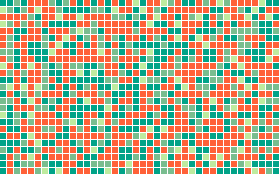

Distribution of values :
2 → 0.082
3 → 0.174
4 → 0.304
5 → 0.44


In [107]:
# Random seed
z = rand(0x00:0xf0, 25, 40);
stabilize!(z, false)
display(draw(z; px_size=6, margin=1))
value_distribution(z)

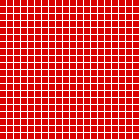

In [81]:
# Uniform pattern
z = zeros(UInt8, 20, 20);
margin = 1
z[margin:end-margin+1, margin:end-margin+1] .= 0xf;
display(draw(z; px_size=6, margin=1))

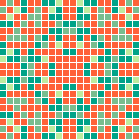

421 steps to reach eq.
Distribution of values :
2 → 0.08
3 → 0.17
4 → 0.26
5 → 0.49


In [82]:
a = copy(z)
println( stabilize!(a, false), " steps to reach eq." )
display(draw(a; px_size=6, margin=1))
value_distribution(a)

24

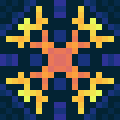

In [86]:
k = k_map(a);
print(maximum(k))
draw(k./maximum(k); px_size=6, margin=0, color_scale=scalar_scale)

## One avalanche

### Animation

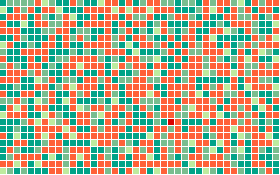

Largest avalanche size is 180
starting at (18, 25)


In [123]:
# Random seed
z = rand(0x00:0xf0, 25, 40);
stabilize!(z, false)

k = k_map(z);
println("Largest avalanche size is ", maximum(k))
println("starting at ", argmax(k).I)

z[argmax(k)] += 1
display(draw(z; px_size=6, margin=1))

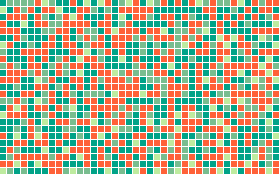

180

In [124]:
a = copy(z);
stabilize!(a, true)

Magick :

    convert -delay 20 -loop 0 anim*.png avalanche01.gif
 

### Extend of one avalanche

In [125]:
function stabilize_map!(z, toppled)
    """"""
    notstable = true
    while notstable
        have_toppled = iterate!(z)
        for i in have_toppled
            toppled[i] += 1
        end
        notstable = length(have_toppled) > 0
    end
    return toppled
end

function stabilize_map!(z)
    toppled = zeros(Int, size(z)...)
    return stabilize_map!(z, toppled)
end

stabilize_map! (generic function with 2 methods)

maximum(toppled) = 6


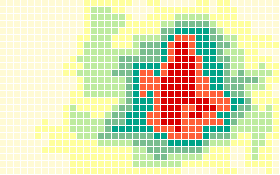

In [153]:
b = copy(z)
toppled = stabilize_map!(b)
@show maximum(toppled)
draw(toppled; px_size=6, margin=1)

### draw causality (v0)

In [154]:
function draw_links(z, links; px_size=6, margin=1)
    @svg begin
        n, m = size(z)
        w = m*(px_size + margin)
        h = n*(px_size + margin)
        Drawing(w, h)
        background("white")
        setantialias(1)

        # colors = reverse(ColorDict["acw"]["Phaedra"])
        # https://randyzwitch.com/NoveltyColors.jl/acw.html
        colors = ["#FFFAD5", "#BEEB9F", "#79BD8F", "#00A388", "#FF6138", "#D90000"] # EC2E49
        for i in CartesianIndices(z)
            color_idx = z[i] + 1 #%length(colors)+1
            if color_idx > length(colors)
                color_idx = length(colors)
            end
            setcolor(colors[color_idx])
            corner = (i.I .- 1).*(px_size + margin) 
            rect(corner[2], corner[1], px_size, px_size, :fill)
        end
        
        center_coords(i) = (reverse(i.I) .- 1).*(px_size + margin) .+ px_size/2
        setline(1)
        setlinecap(:round)
        sethue("black")
        for (i, j) in links

            
            center_i = Point(center_coords(i))
            center_j = Point(center_coords(j))
            d = (center_j - center_i)*0.5
            line(center_i, center_j - d, :stroke)
        end
    end
end

draw_links (generic function with 1 method)

In [155]:
# init
b = copy(z);

links = []
have_toppled_2 = iterate!(b)
notstable = length(have_toppled_2) > 0

# loop
while notstable
    have_toppled_1 = have_toppled_2
    have_toppled_2 = iterate!(b)
    
    for i in have_toppled_1
        for v in voisins
            j = i + v
            if j in have_toppled_2
                push!(links, (i, j))
            end
        end
    end
    
    notstable = length(have_toppled_2) > 0
end

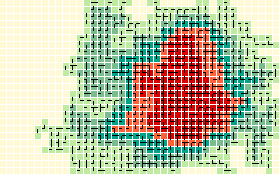

In [156]:
draw_links(toppled, links)

In [157]:
## stats on avalanche size
k = k_map(z);
k_flat = [(i, k[i]) for i in CartesianIndices(k) if k[i]>2];
sort!(k_flat, by=x -> x[2], rev=true);

## Sum of all avalanche

i.e. risk to topple

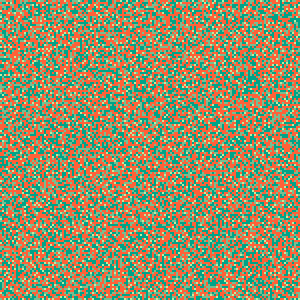

In [444]:
# Random seed
z = rand(0x1:0x20, 150, 150);
stabilize!(z, false)
draw(z; px_size=2, margin=0)

In [137]:
function avalanche_map!(toppled, z)

    not_stable = true
    while not_stable
        have_toppled = iterate!(z)
        for i in have_toppled
            toppled[i] += 1
        end
        not_stable = length(have_toppled) > 0
    end

end

avalanche_map! (generic function with 1 method)

In [138]:
toppled = zeros(UInt32, size(z)...)
b = zeros(UInt8, size(z)...)
for i in CartesianIndices(z)
    copyto!(b, z);
    b[i] += 1
    avalanche_map!(toppled, b)
end

@show convert(Int, maximum(toppled));

convert(Int, maximum(toppled)) = 6018


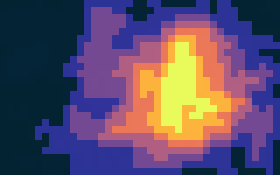

In [141]:
draw(toppled./maximum(toppled); px_size=7, margin=0, color_scale=scalar_scale)

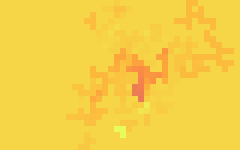

In [159]:
draw(k./maximum(k); px_size=6, margin=0, color_scale=scalar_scale)

## Next

- est-ce que retrouve la courbe de l'article ?
- est-ce les nouveaux equilibres ont les même props. que le 1er après random_seed ?
- dissipative because of edges escaping matter, but what if periodic & non-conservative toppling

- link between more realistic topology model & slope ?
- faster computation:
    - GPU ?
    - keep track of modified cell instead of findall: not better
    - tile&merge stabilize ?